Task1, mse without 2qubit gates

In [4]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the simulator
simulator = AerSimulator()

def create_circuit(params, input_state):
    """
    Creates a parameterized quantum circuit.
    
    Args:
        params (list): List of parameters for rotation gates.
        input_state (str): Input string '00', '01', '10', or '11'.
        
    Returns:
        QuantumCircuit: The constructed circuit.
    """
    qc = QuantumCircuit(2, 1) # 2 qubits, 1 classical bit for measurement
    
    # 1. Encoding
    # Encode classical input into quantum state
    if input_state[0] == '1':
        qc.x(0)
    if input_state[1] == '1':
        qc.x(1)
        
    qc.barrier()
    
    # 2. Parameterized Rotations (Ansatz)
    # We use a hardware efficient ansatz style with rotations and entanglement
    # Note: To simulate XOR, some form of interaction is needed. 
    # We use CRZ (Controlled-RZ) which is a rotation gate on the target qubit controlled by the control qubit.
    
    # Layer 1: Single qubit rotations
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rz(params[2], 0)
    qc.rx(params[3], 1)
    qc.ry(params[4], 1)
    qc.rz(params[5], 1)
    
    qc.barrier()
    
    # 3. Measurement
    # We measure only one qubit (qubit 1) as requested
    qc.measure(1, 0)
    
    return qc

def get_probability(params, input_state):
    """
    Runs the circuit and returns the probability of measuring '1'.
    """
    qc = create_circuit(params, input_state)
    # Transpile for simulator
    compiled_circuit = transpile(qc, simulator)
    # Run
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Calculate probability of outcome '1'
    shots = 1024
    count_1 = counts.get('1', 0)
    return count_1 / shots

def cost_function(params, target_gate):
    """
    Calculates the cost (Mean Squared Error) for a given logic gate.
    """
    inputs = ['00', '01', '10', '11']
    targets = []
    
    if target_gate == 'AND':
        targets = [0, 0, 0, 1]
    elif target_gate == 'OR':
        targets = [0, 1, 1, 1]
    elif target_gate == 'XOR':
        targets = [0, 1, 1, 0]
        
    total_cost = 0
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        total_cost += (prob - targets[i]) ** 2
        
    return total_cost

def train_gate(gate_name):
    print(f"Training {gate_name} gate...")
    # Initialize random parameters (6 parameters based on our circuit)
    initial_params = np.random.rand(6) * 2 * np.pi
    
    # Optimize
    result = minimize(
        cost_function, 
        initial_params, 
        args=(gate_name,), 
        method='COBYLA', 
        options={'maxiter': 200, 'tol': 1e-4}
    )
    
    print(f"Optimization success: {result.success}")
    print(f"Final Cost: {result.fun}")
    return result.x

def evaluate(params, gate_name):
    inputs = ['00', '01', '10', '11']
    print(f"\nResults for {gate_name}:")
    print(f"Input | Prob of prediction | Prediction | Target")
    print("-" * 35)
    
    targets = []
    if gate_name == 'AND': targets = [0, 0, 0, 1]
    elif gate_name == 'OR': targets = [0, 1, 1, 1]
    elif gate_name == 'XOR': targets = [0, 1, 1, 0]
    
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        pred = 1 if prob > 0.5 else 0
        print(f"  {inp}  |        {1 - prob:.3f}       |      {pred}     |   {targets[i]}" if pred == 0 else f"  {inp}  |        {prob:.3f}"  + f"       |      {pred}     |   {targets[i]}")

# --- Main Execution ---

# Train and Evaluate AND
params_and = train_gate('AND')
evaluate(params_and, 'AND')

print("\n")
# Train and Evaluate OR
params_or = train_gate('OR')
evaluate(params_or, 'OR')

print("\n")
# Train and Evaluate XOR
params_xor = train_gate('XOR')
evaluate(params_xor, 'XOR')


Training AND gate...
Optimization success: True
Final Cost: 0.7806921005249023

Results for AND:
Input | Prob of prediction | Prediction | Target
-----------------------------------
  00  |        0.825       |      0     |   0
  01  |        0.839       |      1     |   0
  10  |        0.815       |      0     |   0
  11  |        0.814       |      1     |   1


Training OR gate...
Optimization success: True
Final Cost: 0.7229423522949219

Results for OR:
Input | Prob of prediction | Prediction | Target
-----------------------------------
  00  |        0.708       |      0     |   0
  01  |        0.688       |      1     |   1
  10  |        0.704       |      0     |   1
  11  |        0.710       |      1     |   1


Training XOR gate...
Optimization success: True
Final Cost: 0.9763002395629883

Results for XOR:
Input | Prob of prediction | Prediction | Target
-----------------------------------
  00  |        0.564       |      1     |   0
  01  |        0.585       |      0   

Circuit Visualization for AND gate:



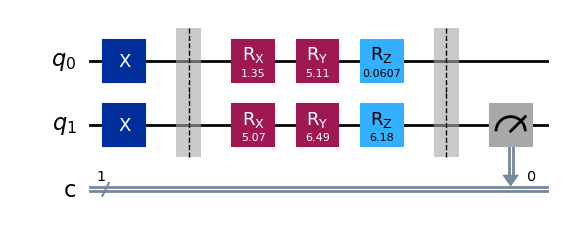

In [ ]:
# visualize the circuit here
print("Circuit Visualization for AND gate:\n")
qc_and = create_circuit(params_and, '11')
    
qc_and.draw(output='mpl')






Circuit Visualization for OR gate:



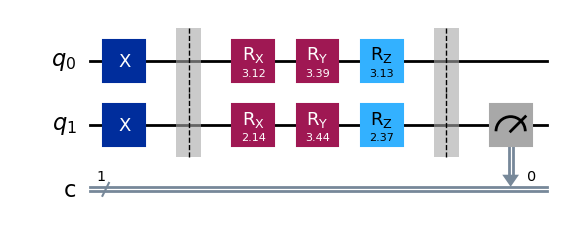

In [48]:
print("\nCircuit Visualization for OR gate:\n")

qc_or = create_circuit(params_or, '11')
qc_or.draw(output='mpl')



Circuit Visualization for XOR gate:



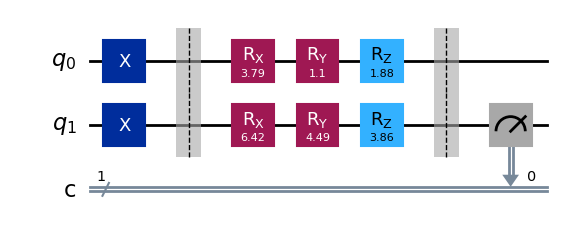

In [49]:

print("\nCircuit Visualization for XOR gate:\n")
qc_xor = create_circuit(params_xor, '11')
qc_xor.draw(output='mpl')

Task 2, mse with entanglement

In [6]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the simulator
simulator = AerSimulator()

def create_circuit(params, input_state):
    """
    Creates a parameterized quantum circuit.
    
    Args:
        params (list): List of parameters for rotation gates.
        input_state (str): Input string '00', '01', '10', or '11'.
        
    Returns:
        QuantumCircuit: The constructed circuit.
    """
    qc = QuantumCircuit(2, 1) # 2 qubits, 1 classical bit for measurement
    
    # 1. Encoding
    # Encode classical input into quantum state
    if input_state[0] == '1':
        qc.x(0)
    if input_state[1] == '1':
        qc.x(1)
        
    qc.barrier()
    
    # 2. Parameterized Rotations (Ansatz)
    # We use a hardware efficient ansatz style with rotations and entanglement
    # Note: To simulate XOR, some form of interaction is needed. 
    # We use CRZ (Controlled-RZ) which is a rotation gate on the target qubit controlled by the control qubit.
    
    # Layer 1: Single qubit rotations
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rz(params[2], 0)
    qc.rx(params[3], 1)
    qc.ry(params[4], 1)
    qc.rz(params[5], 1)

    qc.barrier()

    # Layer 2: Entangling layer (using controlled rotations)

    qc.crz(params[6], 0, 1)
    qc.crx(params[7], 0, 1)
    qc.crz(params[8], 1, 0)
    qc.crx(params[9], 1, 0)

    # Layer 3: Single qubit rotations
    qc.rx(params[10], 0)
    qc.ry(params[11], 0)
    qc.rz(params[12], 0)
    qc.rx(params[13], 1)
    qc.ry(params[14], 1)
    qc.rz(params[15], 1)


    
    qc.barrier()
    
    # 3. Measurement
    # We measure only one qubit (qubit 1) as requested
    qc.measure(1, 0)
    
    return qc

def get_probability(params, input_state):
    """
    Runs the circuit and returns the probability of measuring '1'.
    """
    qc = create_circuit(params, input_state)
    # Transpile for simulator
    compiled_circuit = transpile(qc, simulator)
    # Run
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Calculate probability of outcome '1'
    shots = 1024
    count_1 = counts.get('1', 0)
    return count_1 / shots

def cost_function(params, target_gate):
    """
    Calculates the cost (Mean Squared Error) for a given logic gate.
    """
    inputs = ['00', '01', '10', '11']
    targets = []
    
    if target_gate == 'AND':
        targets = [0, 0, 0, 1]
    elif target_gate == 'OR':
        targets = [0, 1, 1, 1]
    elif target_gate == 'XOR':
        targets = [0, 1, 1, 0]
        
    total_cost = 0
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        total_cost += (prob - targets[i]) ** 2
        
    return total_cost

def train_gate(gate_name):
    print(f"Training {gate_name} gate...")
    # Initialize random parameters (12 parameters based on our circuit)
    initial_params = np.random.rand(16) * 2 * np.pi
    
    # Optimize
    result = minimize(
        cost_function, 
        initial_params, 
        args=(gate_name,), 
        method='COBYLA', 
        options={'maxiter': 200, 'tol': 1e-4}
    )
    
    print(f"Optimization success: {result.success}")
    print(f"Final Cost: {result.fun}")
    return result.x

def evaluate(params, gate_name):
    inputs = ['00', '01', '10', '11']
    print(f"\nResults for {gate_name}:")
    print(f"Input | Prob of prediction | Prediction | Target")
    print("-" * 35)
    
    targets = []
    if gate_name == 'AND': targets = [0, 0, 0, 1]
    elif gate_name == 'OR': targets = [0, 1, 1, 1]
    elif gate_name == 'XOR': targets = [0, 1, 1, 0]
    
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        pred = 1 if prob > 0.5 else 0

        print(f"  {inp}  |        {1 - prob:.3f}       |      {pred}     |   {targets[i]}" if pred == 0 else f"  {inp}  |        {prob:.3f}"  + f"       |      {pred}     |   {targets[i]}")
        

# --- Main Execution ---

# Train and Evaluate AND
params_and = train_gate('AND')
evaluate(params_and, 'AND')

print("\n")
# Train and Evaluate OR
params_or = train_gate('OR')
evaluate(params_or, 'OR')

print("\n")
# Train and Evaluate XOR
params_xor = train_gate('XOR')
evaluate(params_xor, 'XOR')


Training AND gate...
Optimization success: True
Final Cost: 0.37278270721435547

Results for AND:
Input | Prob of prediction | Prediction | Target
-----------------------------------
  00  |        0.629       |      0     |   0
  01  |        0.593       |      0     |   0
  10  |        0.729       |      0     |   0
  11  |        0.952       |      1     |   1


Training OR gate...
Optimization success: True
Final Cost: 0.5558605194091797

Results for OR:
Input | Prob of prediction | Prediction | Target
-----------------------------------
  00  |        0.822       |      0     |   0
  01  |        0.501       |      1     |   1
  10  |        0.532       |      1     |   1
  11  |        0.858       |      1     |   1


Training XOR gate...
Optimization success: True
Final Cost: 9.34600830078125e-05

Results for XOR:
Input | Prob of prediction | Prediction | Target
-----------------------------------
  00  |        0.998       |      0     |   0
  01  |        0.999       |      1

Circuit Visualization for AND gate:



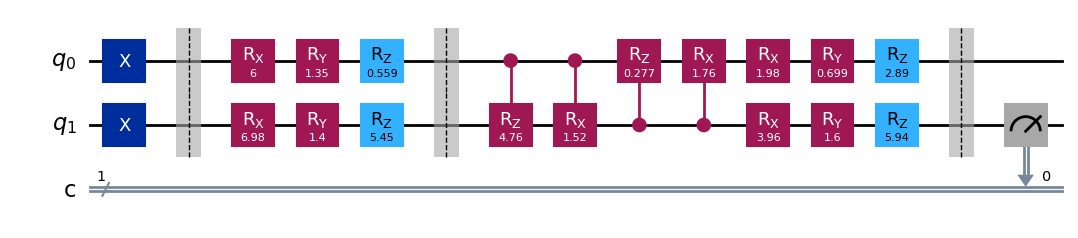

In [23]:
# Visualize the circuit
print("Circuit Visualization for AND gate:\n")
qc_and = create_circuit(params_and, '11')
qc_and.draw(output='mpl')


Circuit Visualization for OR gate:



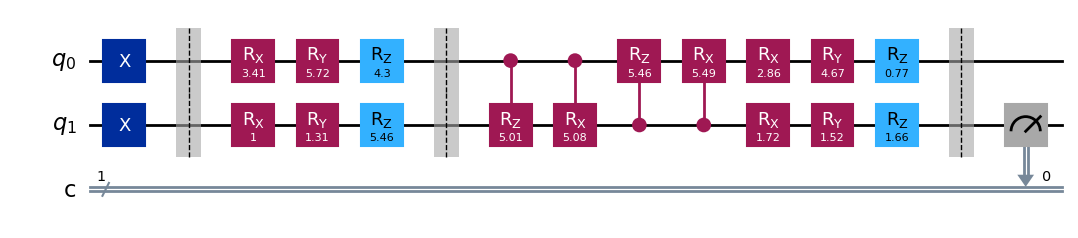

In [25]:
print("\nCircuit Visualization for OR gate:\n")
qc_or = create_circuit(params_or, '11')
qc_or.draw(output='mpl')


Circuit Visualization for XOR gate:



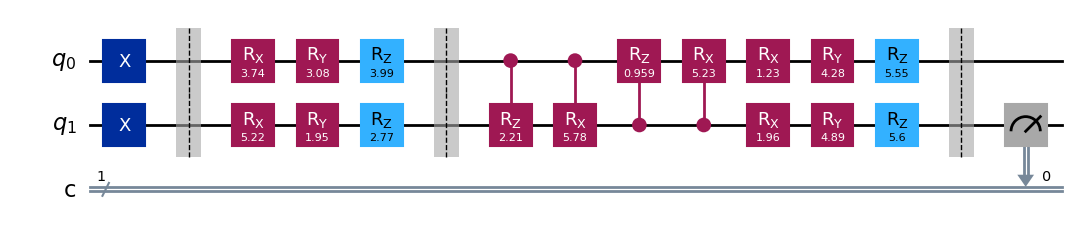

In [26]:
print("\nCircuit Visualization for XOR gate:\n")
qc_xor = create_circuit(params_xor, '11')
qc_xor.draw(output='mpl')

Task 3 mse entanglement and angle encoding

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the simulator
simulator = AerSimulator()

def create_circuit(params, input_state):
    """
    Creates a parameterized quantum circuit.
    
    Args:
        params (list): List of parameters for rotation gates.
        input_state (str): Input string '00', '01', '10', or '11'.
        
    Returns:
        QuantumCircuit: The constructed circuit.
    """
    qc = QuantumCircuit(2, 1) # 2 qubits, 1 classical bit for measurement
    
    # 1. Encoding
    # Encode classical input into quantum state
    if input_state[0] == '1':
        qc.rx(np.pi/2, 0)
    if input_state[1] == '1':
        qc.rx(np.pi/2, 1)
        
    qc.barrier()
    
    # 2. Parameterized Rotations (Ansatz)
    # We use a hardware efficient ansatz style with rotations and entanglement
    # Note: To simulate XOR, some form of interaction is needed. 
    # We use CRZ (Controlled-RZ) which is a rotation gate on the target qubit controlled by the control qubit.
    
    # Layer 1: Single qubit rotations
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rz(params[2], 0)
    qc.rx(params[3], 1)
    qc.ry(params[4], 1)
    qc.rz(params[5], 1)

    qc.crz(params[6], 0, 1)
    qc.crx(params[7], 0, 1)
    qc.crz(params[8], 1, 0)
    qc.crx(params[9], 1, 0)


    qc.rx(params[10], 0)
    qc.ry(params[11], 0)
    qc.rz(params[12], 0)
    qc.rx(params[13], 1)
    qc.ry(params[14], 1)
    qc.rz(params[15], 1)


    
    qc.barrier()
    
    # 3. Measurement
    # We measure only one qubit (qubit 1) as requested
    qc.measure(1, 0)
    
    return qc

def get_probability(params, input_state):
    """
    Runs the circuit and returns the probability of measuring '1'.
    """
    qc = create_circuit(params, input_state)
    # Transpile for simulator
    compiled_circuit = transpile(qc, simulator)
    # Run
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Calculate probability of outcome '1'
    shots = 1024
    count_1 = counts.get('1', 0)
    return count_1 / shots

def cost_function(params, target_gate):
    """
    Calculates the cost (Mean Squared Error) for a given logic gate.
    """
    inputs = ['00', '01', '10', '11']
    targets = []
    
    if target_gate == 'AND':
        targets = [0, 0, 0, 1]
    elif target_gate == 'OR':
        targets = [0, 1, 1, 1]
    elif target_gate == 'XOR':
        targets = [0, 1, 1, 0]
        
    total_cost = 0
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        total_cost += (prob - targets[i]) ** 2
        
    return total_cost

def train_gate(gate_name):
    print(f"Training {gate_name} gate...")
    # Initialize random parameters (16 parameters based on our circuit)
    initial_params = np.random.rand(16) * 2 * np.pi
    
    # Optimize
    result = minimize(
        cost_function, 
        initial_params, 
        args=(gate_name,), 
        method='COBYLA', 
        options={'maxiter': 200, 'tol': 1e-4}
    )
    
    print(f"Optimization success: {result.success}")
    print(f"Final Cost: {result.fun}")
    return result.x

def evaluate(params, gate_name):
    inputs = ['00', '01', '10', '11']
    print(f"\nResults for {gate_name}:")
    print(f"Input | Prob of prediction | Prediction | Target")
    print("-" * 35)
    
    targets = []
    if gate_name == 'AND': targets = [0, 0, 0, 1]
    elif gate_name == 'OR': targets = [0, 1, 1, 1]
    elif gate_name == 'XOR': targets = [0, 1, 1, 0]
    
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        pred = 1 if prob > 0.5 else 0
        print(f"  {inp}  |        {1 - prob:.3f}       |      {pred}     |   {targets[i]}" if pred == 0 else f"  {inp}  |        {prob:.3f}"  + f"       |      {pred}     |   {targets[i]}")
# --- Main Execution ---

# Train and Evaluate AND
params_and = train_gate('AND')
evaluate(params_and, 'AND')

print("\n")
# Train and Evaluate OR
params_or = train_gate('OR')
evaluate(params_or, 'OR')

print("\n")
# Train and Evaluate XOR
params_xor = train_gate('XOR')
evaluate(params_xor, 'XOR')


Training AND gate...


Circuit Visualization for AND gate:



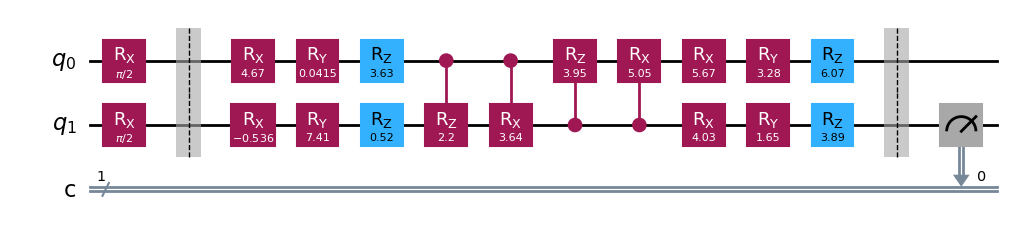

In [29]:
# include the circuit visualization here
print("Circuit Visualization for AND gate:\n")
qc_and = create_circuit(params_and, '11')
qc_and.draw(output='mpl')


Circuit Visualization for OR gate:



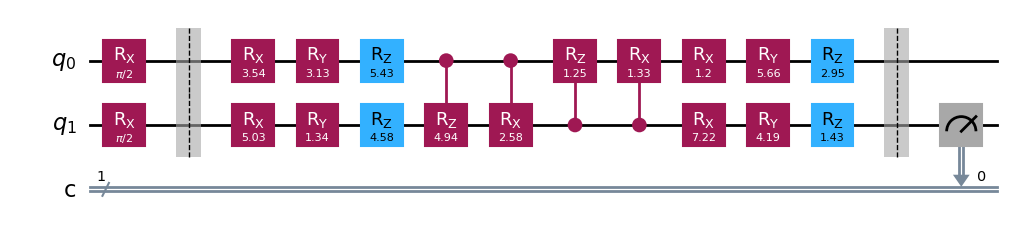

In [30]:
print("\nCircuit Visualization for OR gate:\n")
qc_or = create_circuit(params_or, '11')
qc_or.draw(output='mpl')


Circuit Visualization for XOR gate:



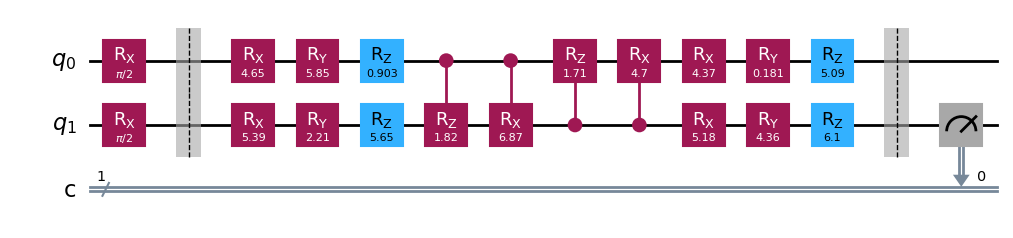

In [32]:
print("\nCircuit Visualization for XOR gate:\n")
qc_xor = create_circuit(params_xor, '11')
qc_xor.draw(output='mpl')


tasks 1 and 2 with cross entropy loss

In [8]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the simulator
simulator = AerSimulator()

def create_circuit(params, input_state):
    """
    Creates a parameterized quantum circuit.
    
    Args:
        params (list): List of parameters for rotation gates.
        input_state (str): Input string '00', '01', '10', or '11'.
        
    Returns:
        QuantumCircuit: The constructed circuit.
    """
    qc = QuantumCircuit(2, 1) # 2 qubits, 1 classical bit for measurement
    
    # 1. Encoding
    # Encode classical input into quantum state
    if input_state[0] == '1':
        qc.x(0)
    if input_state[1] == '1':
        qc.x(1)
        
    qc.barrier()
    
    # 2. Parameterized Rotations (Ansatz)
    # We use a hardware efficient ansatz style with rotations and entanglement
    # Note: To simulate XOR, some form of interaction is needed. 
    # We use CRZ (Controlled-RZ) which is a rotation gate on the target qubit controlled by the control qubit.
    
    # Layer 1: Single qubit rotations
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rz(params[2], 0)
    qc.rx(params[3], 1)
    qc.ry(params[4], 1)
    qc.rz(params[5], 1)
    
    qc.barrier()
    
    # 3. Measurement
    # We measure only one qubit (qubit 1) as requested
    qc.measure(1, 0)
    
    return qc

def get_probability(params, input_state):
    """
    Runs the circuit and returns the probability of measuring '1'.
    """
    qc = create_circuit(params, input_state)
    # Transpile for simulator
    compiled_circuit = transpile(qc, simulator)
    # Run
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Calculate probability of outcome '1'
    shots = 1024
    count_1 = counts.get('1', 0)
    return count_1 / shots

def cost_function(params, target_gate):
    """
    Calculates the cost (Cross Entropy Loss) for a given logic gate.
    """
    inputs = ['00', '01', '10', '11']
    targets = []
    
    if target_gate == 'AND':
        targets = [0, 0, 0, 1]
    elif target_gate == 'OR':
        targets = [0, 1, 1, 1]
    elif target_gate == 'XOR':
        targets = [0, 1, 1, 0]
        
    total_cost = 0
    epsilon = 1e-9 # Avoid log(0)
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        prob = np.clip(prob, epsilon, 1 - epsilon)
        target = targets[i]
        # Binary Cross Entropy Loss
        loss = - (target * np.log(prob) + (1 - target) * np.log(1 - prob))
        total_cost += loss
        
    return total_cost

def train_gate(gate_name):
    print(f"Training {gate_name} gate...")
    # Initialize random parameters (6 parameters based on our circuit)
    initial_params = np.random.rand(6) * 2 * np.pi
    
    # Optimize
    result = minimize(
        cost_function, 
        initial_params, 
        args=(gate_name,), 
        method='COBYLA', 
        options={'maxiter': 200, 'tol': 1e-4}
    )
    
    print(f"Optimization success: {result.success}")
    print(f"Final Cost: {result.fun}")
    return result.x

def evaluate(params, gate_name):
    inputs = ['00', '01', '10', '11']
    print(f"\nResults for {gate_name}:")
    print(f"Input | Prob(1) | Prediction | Target")
    print("-" * 35)
    
    targets = []
    if gate_name == 'AND': targets = [0, 0, 0, 1]
    elif gate_name == 'OR': targets = [0, 1, 1, 1]
    elif gate_name == 'XOR': targets = [0, 1, 1, 0]
    
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        pred = 1 if prob > 0.5 else 0
        print(f"  {inp}  |  {prob:.3f}  |      {pred}     |   {targets[i]}")

# --- Main Execution ---

# Train and Evaluate AND
params_and = train_gate('AND')
evaluate(params_and, 'AND')

print("\n")
# Train and Evaluate OR
params_or = train_gate('OR')
evaluate(params_or, 'OR')

print("\n")
# Train and Evaluate XOR
params_xor = train_gate('XOR')
evaluate(params_xor, 'XOR')


Training AND gate...
Optimization success: True
Final Cost: 2.40439090561842

Results for AND:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.217  |      0     |   0
Optimization success: True
Final Cost: 2.40439090561842

Results for AND:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.217  |      0     |   0
  01  |  0.761  |      1     |   0
  10  |  0.232  |      0     |   0
  11  |  0.788  |      1     |   1


Training OR gate...
  01  |  0.761  |      1     |   0
  10  |  0.232  |      0     |   0
  11  |  0.788  |      1     |   1


Training OR gate...
Optimization success: True
Final Cost: 2.3246719678801906

Results for OR:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.242  |      0     |   0
Optimization success: True
Final Cost: 2.3246719678801906

Results for OR:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.242  |      0  

Entangled case with Cross entropy loss calculation 

In [9]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the simulator
simulator = AerSimulator()

def create_circuit(params, input_state):
    """
    Creates a parameterized quantum circuit.
    
    Args:
        params (list): List of parameters for rotation gates.
        input_state (str): Input string '00', '01', '10', or '11'.
        
    Returns:
        QuantumCircuit: The constructed circuit.
    """
    qc = QuantumCircuit(2, 1) # 2 qubits, 1 classical bit for measurement
    
    # 1. Encoding
    # Encode classical input into quantum state
    if input_state[0] == '1':
        qc.x(0)
    if input_state[1] == '1':
        qc.x(1)
        
    qc.barrier()
    
    # 2. Parameterized Rotations (Ansatz)
    # We use a hardware efficient ansatz style with rotations and entanglement
    # Note: To simulate XOR, some form of interaction is needed. 
    # We use CRZ (Controlled-RZ) which is a rotation gate on the target qubit controlled by the control qubit.
    
    # Layer 1: Single qubit rotations
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rz(params[2], 0)
    qc.rx(params[3], 1)
    qc.ry(params[4], 1)
    qc.rz(params[5], 1)

    qc.barrier()

    # Layer 2: Entangling layer (using controlled rotations)

    qc.crz(params[6], 0, 1)
    qc.crx(params[7], 0, 1)
    qc.crz(params[8], 1, 0)
    qc.crx(params[9], 1, 0)

    # Layer 3: Single qubit rotations
    qc.rx(params[10], 0)
    qc.ry(params[11], 0)
    qc.rz(params[12], 0)
    qc.rx(params[13], 1)
    qc.ry(params[14], 1)
    qc.rz(params[15], 1)


    
    qc.barrier()
    
    # 3. Measurement
    # We measure only one qubit (qubit 1) as requested
    qc.measure(1, 0)
    
    return qc

def get_probability(params, input_state):
    """
    Runs the circuit and returns the probability of measuring '1'.
    """
    qc = create_circuit(params, input_state)
    # Transpile for simulator
    compiled_circuit = transpile(qc, simulator)
    # Run
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Calculate probability of outcome '1'
    shots = 1024
    count_1 = counts.get('1', 0)
    return count_1 / shots

def cost_function(params, target_gate):
    """
    Calculates the cost (Mean Squared Error) for a given logic gate.
    """
    inputs = ['00', '01', '10', '11']
    targets = []
    
    if target_gate == 'AND':
        targets = [0, 0, 0, 1]
    elif target_gate == 'OR':
        targets = [0, 1, 1, 1]
    elif target_gate == 'XOR':
        targets = [0, 1, 1, 0]
        
    total_cost = 0
    epsilon = 1e-9 # Avoid log(0)
    for i, inp in enumerate(inputs):
        prob = get_probability(params, inp)
        prob = np.clip(prob, epsilon, 1 - epsilon)
        target = targets[i]
        # Binary Cross Entropy Loss
        loss = - (target * np.log(prob) + (1 - target) * np.log(1 - prob))
        total_cost += loss
        
    return total_cost

def train_gate(gate_name):
    print(f"Training {gate_name} gate...")
    # Initialize random parameters (12 parameters based on our circuit)
    initial_params = np.random.rand(16) * 2 * np.pi
    
    # Optimize
    result = minimize(
        cost_function, 
        initial_params, 
        args=(gate_name,), 
        method='COBYLA', 
        options={'maxiter': 200, 'tol': 1e-4}
    )
    
    print(f"Optimization success: {result.success}")
    print(f"Final Cost: {result.fun}")
    return result.x

def evaluate(params, gate_name):
    inputs = ['00', '01', '10', '11']
    print(f"\nResults for {gate_name}:")
    print(f"Input | Prob(1) | Prediction | Target")
    print("-" * 35)
    
    targets = []
    if gate_name == 'AND': targets = [0, 0, 0, 1]
    elif gate_name == 'OR': targets = [0, 1, 1, 1]
    elif gate_name == 'XOR': targets = [0, 1, 1, 0]
    
    for (i, inp) in enumerate(inputs):
        prob = get_probability(params, inp)
        pred = 1 if prob > 0.5 else 0
        print(f"  {inp}  |  {prob:.3f}  |      {pred}     |   {targets[i]}")

# --- Main Execution ---

# Train and Evaluate AND
params_and = train_gate('AND')
evaluate(params_and, 'AND')

print("\n")
# Train and Evaluate OR
params_or = train_gate('OR')
evaluate(params_or, 'OR')

print("\n")
# Train and Evaluate XOR
params_xor = train_gate('XOR')
evaluate(params_xor, 'XOR')


Training AND gate...
Optimization success: True
Final Cost: 1.2546306472011695

Results for AND:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.361  |      0     |   0
Optimization success: True
Final Cost: 1.2546306472011695

Results for AND:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.361  |      0     |   0
  01  |  0.253  |      0     |   0
  10  |  0.445  |      0     |   0
  01  |  0.253  |      0     |   0
  10  |  0.445  |      0     |   0
  11  |  0.995  |      1     |   1


Training OR gate...
  11  |  0.995  |      1     |   1


Training OR gate...
Optimization success: True
Final Cost: 1.2154916471307413

Results for OR:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.003  |      0     |   0
Optimization success: True
Final Cost: 1.2154916471307413

Results for OR:
Input | Prob(1) | Prediction | Target
-----------------------------------
  00  |  0.003  |     